## Inverse Perspective Mapping
This notebook performs inverse Perspective mapping in an interactive way.
The necessary data are stored in an .npz file for lane detection algorithm to read.

### Reference:
https://github.com/JonathanCMitchell/Advanced-Lane-Line-Detection/blob/master/Perspective_transform.ipynb

In [1]:
import numpy as np
import cv2
import yaml
import matplotlib.pyplot as plt
from math import tan
%matplotlib inline

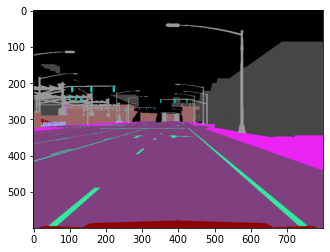

In [2]:
# Prepare data
config_path = r"../config/town03.yaml"
with open(config_path, 'r') as config_file:
    config_args = yaml.safe_load(config_file)
# FOV in deg
fov = int(config_args['sensor']['front_camera']['fov'])

# Image resolution
res_h = int(config_args['sensor']['front_camera']['res_h'])
res_v = int(config_args['sensor']['front_camera']['res_v'])

# Image for calibration
calib_img = cv2.imread('./calib_images/ss_image.png')
plt.imshow(calib_img)

In [3]:
# Vanish point
# In Carla simulation we have an ideal vanishing point at center
vp = (res_h//2, res_v//2)

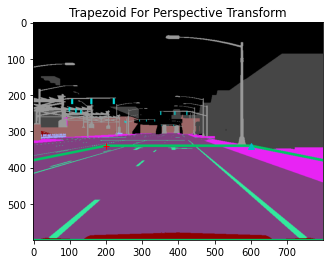

In [4]:
def find_pt_inline(p1, p2, y):
    """
    Here we use point-slope formula in order to find a point that is present on the line
    that passes through our vanishing point (vp). 
    input: points p1, p2, and y. They come is as tuples [x, y]
    We then use the point-slope formula: y - b = m(x - a)
    y: y-coordinate of desired point on the line
    x: x-coordinate of desired point on the line
    m: slope
    b: y-coordinate of p1
    a: x-coodrinate of p1
    x = p1x + (1/m)(y - p1y)
    """
    m_inv = (p2[0] - p1[0]) / float(p2[1] - p1[1])
    Δy = (y - p1[1])
    x = p1[0] + m_inv * Δy
    return [x, y]

top = vp[1] + 40
bot = 600

# Make a large width so that you can grab the lines on the challenge video
width = 400

p1 = [vp[0] - width/2, top]
p2 = [vp[0] + width/2, top]
p3 = find_pt_inline(p2, vp, bot)
p4 = find_pt_inline(p1, vp, bot)

src_pts = np.float32([p1, p2, p3, p4])

# The destination image size after warping the trapezoid to the bird's eye view
dst_size = (400, 600)   # width * height
dst_pts = np.float32([[0, 0], [dst_size[0], 0],
                       [dst_size[0], dst_size[1]],
                       [0, dst_size[1]]])

# Draw Trapezoid
calib_img_copy = calib_img.copy()
cv2.polylines(calib_img_copy, [src_pts.astype(np.int32)],True, (0,200,100), thickness=5)
plt.plot(p1[0], p1[1], 'r+')
plt.plot(p2[0], p2[1], 'c^')
plt.plot(p3[0], p3[1], 'r^')
plt.plot(p4[0], p4[1], 'g^')
plt.title('Trapezoid For Perspective Transform')
plt.imshow(calib_img_copy)

M: [[-1.33333333e-01 -6.66666667e-01  2.53333333e+02]
 [ 0.00000000e+00 -2.30769231e+00  7.84615385e+02]
 [-0.00000000e+00 -3.33333333e-03  1.00000000e+00]]


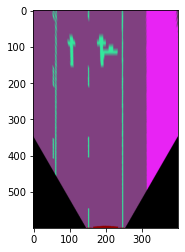

In [5]:
M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
print('M: {}'.format(M))
warped_shape = dst_size
warped = cv2.warpPerspective(calib_img, M, warped_shape)
plt.imshow(warped)

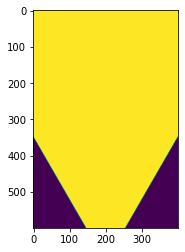

In [6]:
valid_mask = (warped[:, :, 0] != 0)
plt.imshow(valid_mask.astype(np.uint8))

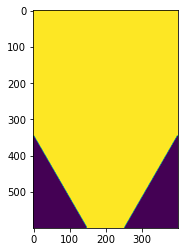

In [7]:
# Dilate (expand) the invalid regions a bit, i.e. shrink the valid regions a bit.
invalid_mask = np.invert(valid_mask)
# Ref: https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/
invalid_mask = cv2.dilate(invalid_mask.astype(np.uint8), kernel=np.ones((3,3), np.uint8), iterations=2)
valid_mask = np.invert(invalid_mask.astype(np.bool))
plt.imshow(valid_mask.astype(np.uint8))

In [8]:
# To find the invalid triangles
half_mask = valid_mask[:, :int(valid_mask.shape[1]/2)]
invalid_y, invalid_x = np.where(half_mask == 0)
invalid_triangle_width = max(invalid_x)
invalid_triangle_height = invalid_mask.shape[0] - min(invalid_y)

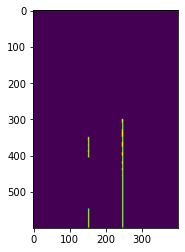

In [9]:
# Compute x per pixel and y per pixel
lane_img = np.load('./calib_images/lane_image.npy')
warped_lane_img = cv2.warpPerspective(lane_img.astype(np.uint8), M, warped_shape)

# Mask the image so the arrows don't affect the computation
mask = np.ones(warped_lane_img.shape, dtype=np.uint8)
mask[:, :invalid_triangle_width] = 0
mask[:, mask.shape[1] - invalid_triangle_width:] = 0
mask[:mask.shape[0]//2, :] = 0
warped_lane_img = warped_lane_img & mask
plt.imshow(warped_lane_img)

Pixels per meter in x: 26.83172319031997


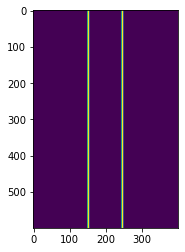

In [10]:
mom = cv2.moments(warped_lane_img[:,:warped_shape[0]//2].astype(np.uint8))
x1 = mom["m10"]/mom["m00"]
mom = cv2.moments(warped_lane_img[:,warped_shape[0]//2:].astype(np.uint8))
x2 = warped_shape[0]//2 + mom["m10"]/mom["m00"]
warped_lane_img_copy = warped_lane_img.copy()
cv2.line(warped_lane_img_copy, (int(x1), 0), (int(x1), warped_shape[1]), (255, 0, 0), 3)
cv2.line(warped_lane_img_copy, (int(x2), 0), (int(x2), warped_shape[1]), (255, 0, 0), 3)

plt.imshow(warped_lane_img_copy)

px_per_meter_x = (x2 - x1) / 3.5    # 3.5 is the known lane width
print('Pixels per meter in x: {}'.format(px_per_meter_x))

In [11]:
# Construct intrinsic calibration matrix of semantic camera
# FOV (in rad)
fov_rad = fov * np.pi / 180  # 60 degrees
# Focal length of semantic camera (in pixel)
f = res_h/2/tan(fov_rad/2)
# Intrinsic matrix
K = np.array([[f, 0, res_h/2], 
              [0, f, res_v/2],
              [0, 0, 1]])

# Compute px_per_meter_y
L = np.linalg.inv(M @ K)
px_per_meter_y = px_per_meter_x * np.linalg.norm(L[:, 0]) / np.linalg.norm(L[:, 1])
print('Pixels per meter in y: {}'.format(px_per_meter_y))

Pixels per meter in y: 26.81186989630283


In [12]:
# Calculate x distance from the camera to the point where the FOV intersects the flat ground
# Camera height from the ground
cam_height = config_args['sensor']['front_camera']['pos_z']
dist_to_intersect = f / (res_v / 2) * cam_height

In [13]:
np.savez('ipm_data', 
    M=M, 
    bev_size=dst_size,  # bev: bird's eye view
    valid_mask=valid_mask,
    invalid_triangle_width=invalid_triangle_width,
    invalid_triangle_height=invalid_triangle_height,
    px_per_meter_x=px_per_meter_x,
    px_per_meter_y=px_per_meter_y,
    dist_to_intersect=dist_to_intersect)